In [26]:
%matplotlib widget
import os
from pathlib import Path
import struct
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import colorcet as cc
from skimage.morphology import binary_erosion, binary_dilation, dilation, disk, skeletonize, medial_axis
from skimage.filters import sobel
from skimage.measure import find_contours, inertia_tensor
from skimage.feature import corner_harris, corner_peaks
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.ndimage import generic_filter
from scipy.spatial import ConvexHull, QhullError
from shapely import concave_hull, MultiPoint, Polygon
from libksc import load_terrain_dat, save_terrain_dat, save_terrain_dat2, BinaryImage_DBSCAN, skeleton_dir, patches_dir

### Function definitions

In [10]:
def skeleton_dir(image, window_size=11):
    '''
    Computes the angle for each pixel of a skeleton
    '''
    offset = (window_size - 1) // 2
    out = np.full(image.shape, np.nan)
    for i in tqdm(range(image.shape[0]), leave=False):
        for j in range(image.shape[1]):
            if image[i, j] < 1:
                continue

            window = image[i-offset:i+offset+1, j-offset:j+offset+1]
            _, eig_vecs = np.linalg.eigh(inertia_tensor(window))

            if  eig_vecs[0, 1] == 0:
                out[i, j] = np.pi / 2
            else:
                out[i, j] = -np.arctan(eig_vecs[0, 0] / eig_vecs[0, 1])
    return out

## Processing roads
### Load data

In [5]:
df_road = pd.DataFrame(load_terrain_dat('Road.bin')[1]).transpose()
header, _ = load_terrain_dat('Road.bin')

### Skeletonize

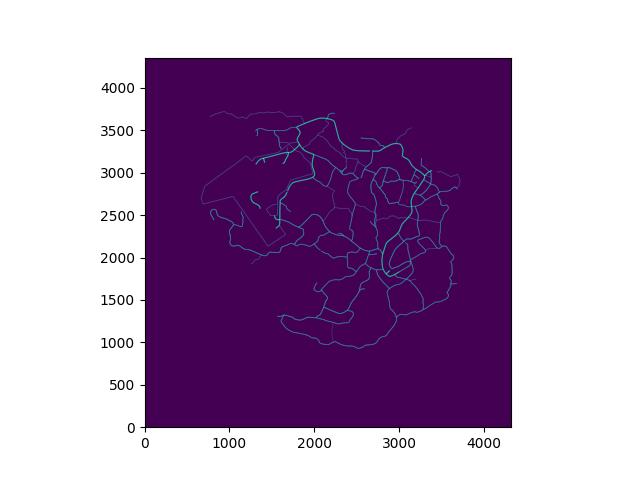

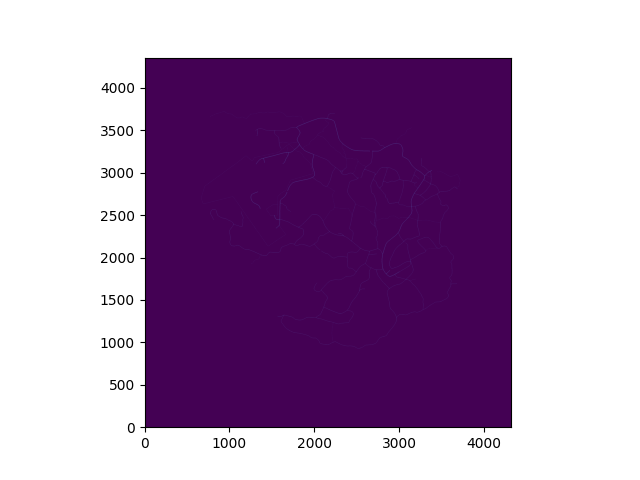

In [6]:
plt.figure()
plt.imshow(df_road, origin='lower')
df_road_skeleton, df_road_skeleton_radius  = medial_axis(df_road.values.copy(order='C'), return_distance=True)
plt.figure()
plt.imshow(df_road_skeleton * df_road_skeleton_radius, origin='lower')

### Detect intersections and remove them

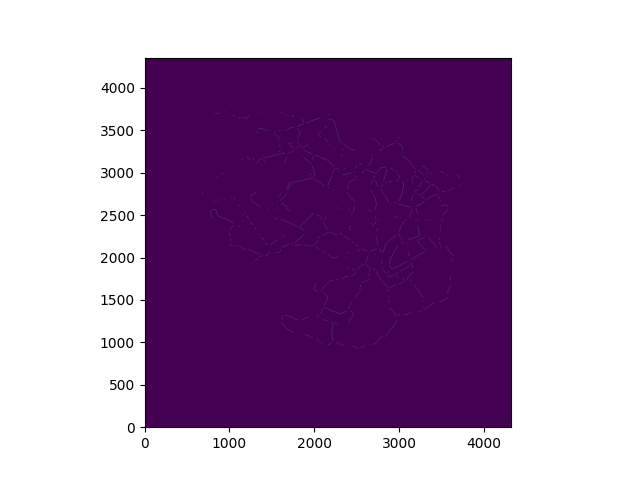

In [12]:
# Sekeleton pixels within this distance to an intersection will be removed
intersection_radius = 10

df_road_corners = pd.DataFrame(corner_harris(df_road_skeleton))
df_road_corners /= df_road_corners.max().max()
df_road_corners = df_road_corners > 0.1
df_road_corners = pd.DataFrame(binary_dilation(df_road_corners, disk(intersection_radius)))
plt.figure()
plt.imshow(df_road_skeleton & ~df_road_corners, origin='lower')

### Compute skeleton pixel angles

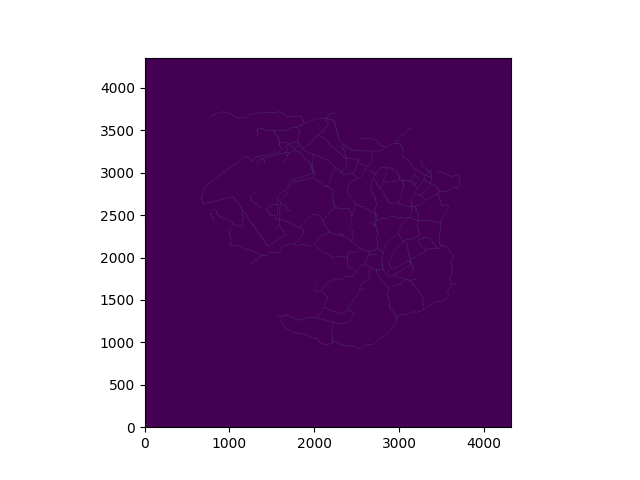

In [14]:
df_road_skeleton_dir = skeleton_dir(df_road_skeleton.astype(np.float32), 11)
plt.figure()
plt.imshow(np.nan_to_num(df_road_skeleton_dir / (np.pi/2) + 1, nan=-2), vmin=-2, vmax=2, origin='lower')

### Split skeleton by their radius and store them

  0%|          | 0/4359 [00:00<?, ?it/s]

100%|██████████| 4359/4359 [00:24<00:00, 178.50it/s]


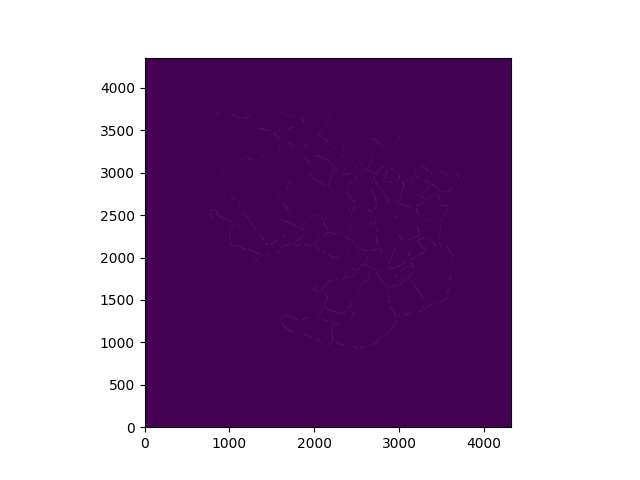

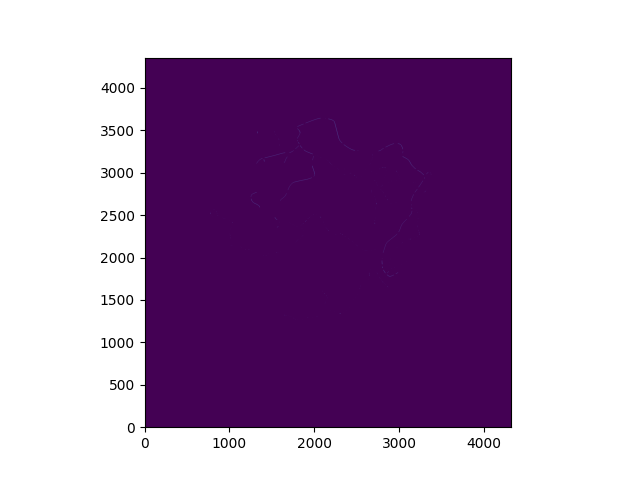

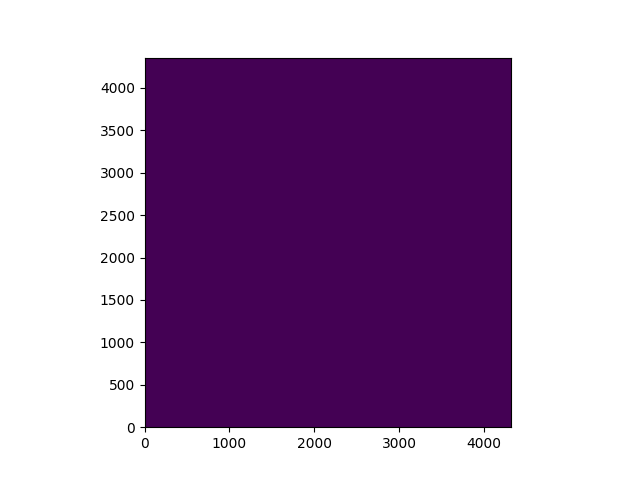

In [15]:
terrain_slots = []

for label, min_radius, max_radius in [('SLOT_ROAD_SMALL', 0, 2.5), ('SLOT_ROAD_MEDIUM', 2.5, 4.8), ('SLOT_ROAD_LARGE', 4.8, np.inf)]:
    out = df_road_skeleton_dir.copy()
    out[df_road_corners] = np.nan

    if min_radius > 0:
        out[min_radius > df_road_skeleton_radius] = np.nan

    if max_radius < np.inf:
        out[max_radius < df_road_skeleton_radius] = np.nan

    x_list = []
    z_list = []
    val_list = []

    for i in tqdm(range(out.shape[0]), leave=True):
        for j in range(out.shape[1]):
            val = out[i, j]

            if np.isnan(val):
                continue
            
            x_list.append(j + header.x_min)
            z_list.append(i + header.z_min)
            val_list.append(val)

    terrain_slots.append((label, x_list, z_list, val_list))

    plt.figure()
    plt.imshow(np.nan_to_num(out / (np.pi/2) + 1, nan=-2), vmin=-2, vmax=2, origin='lower')


---
## Processing flat and emtpy areas
### Load data

In [16]:
df_place = pd.DataFrame(load_terrain_dat('Placement.bin')[1]).transpose()
header, _ = load_terrain_dat('Placement.bin')

### Erode for different slot sizes, assign angles to patches and store them

100%|██████████| 4359/4359 [00:05<00:00, 857.83it/s] 


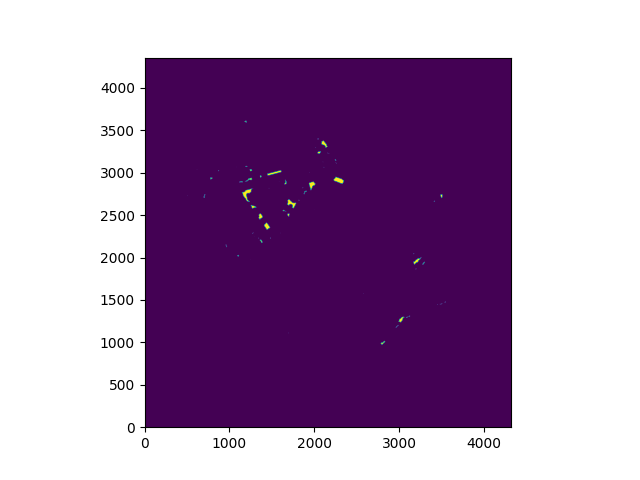

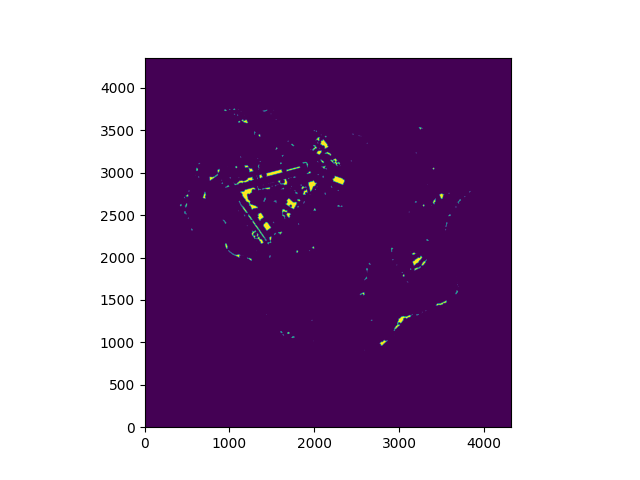

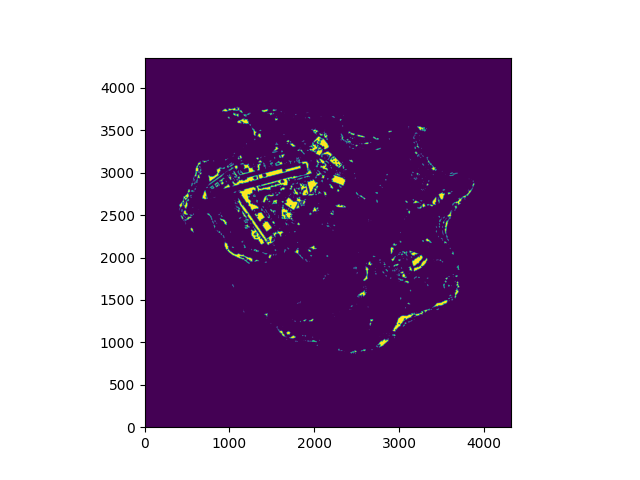

In [17]:
for label, radius in [('SLOT_FLAT_LARGE', 21), ('SLOT_FLAT_MEDIUM', 13), ('SLOT_FLAT_SMALL', 6)]:
    out = binary_erosion(df_place, disk(radius))
    angles = patches_dir(out)

    x_list = []
    z_list = []
    val_list = []

    for i in tqdm(range(out.shape[0]), leave=True):
        for j in range(out.shape[1]):
            val = out[i, j]

            if not val:
                continue
            
            x_list.append(j + header.x_min)
            z_list.append(i + header.z_min)
            val_list.append(angles[i, j])

    terrain_slots.append((label, x_list, z_list, val_list))

    if label == 'SLOT_FLAT_SMALL':
        df_slot_flat_small = out

    plt.figure()
    plt.imshow(out, origin='lower')

---
## Processing buildings
### Load data

<Axes: xlabel='0', ylabel='1'>

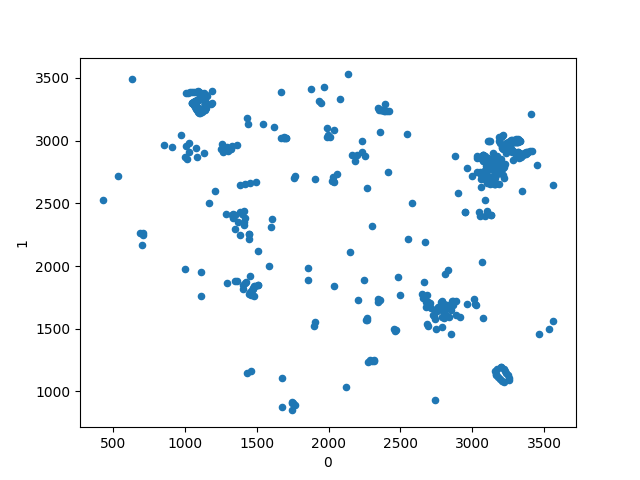

In [19]:
def is_valid_resource(res_name):
    '''
    Returns true if the resource should be considered as a building
    '''
    for blacklisted_pattern in [
        'Bridge',
        'Cemeter',
        'Ruin',
        'Wall',
        'PierWooden',
        'Pier_',
        'Doorstep',
    ]:
        if blacklisted_pattern in res_name:
            return False
    
    return True

df_buildings = np.empty(shape=(0,2))
with open('SCR_DestructibleBuildingEntity.dat', 'r') as stream:
    for line in stream:
        res_name, vect = line.split(';')

        if not is_valid_resource(res_name):
            continue

        coords = vect[1:-2].split(',')
        point = [float(coords[0]), float(coords[2])]
        df_buildings = np.append(df_buildings, [point], axis=0)

df_buildings = pd.DataFrame(df_buildings)
df_buildings.plot.scatter(x=0, y=1)

### Cluster buidlings

<Axes: xlabel='0', ylabel='1'>

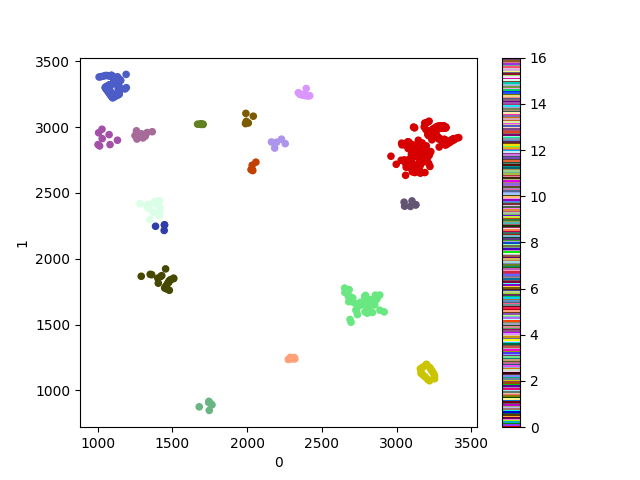

In [20]:
labels = DBSCAN(eps=75, min_samples=5).fit_predict(df_buildings)
df_buildings = df_buildings[labels >= 0]
labels = labels [labels >= 0]
df_buildings.plot.scatter(x=0, y=1, c=labels, cmap=cc.cm.glasbey)

AttributeError: 'Polygon' object has no attribute 'vertices'

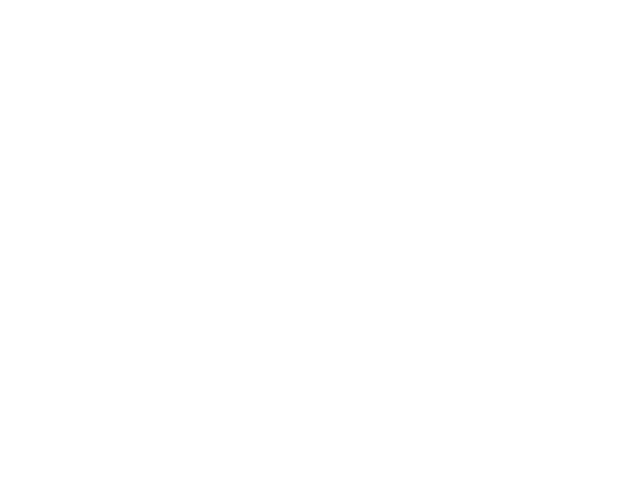

In [29]:
polygons = []
plt.figure()
for label in range(labels.max() + 1):
    points = df_buildings[labels == label].values
    hull = concave_hull(MultiPoint(points))

    if polygon.area < 150:
        continue

    polygon = hull.buffer(50, join_style='mitre', mitre_limit=1)
    polygons.append(polygon)
    vertices = np.array(polygon.exterior.coords)

    plt.plot(np.hstack([vertices[:, 0], [vertices[0, 0]]]), np.hstack([vertices[:, 1], [vertices[0, 1]]]), 'k-')
    for simplex in polygon.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'r-')


### Compute hull for each cluster

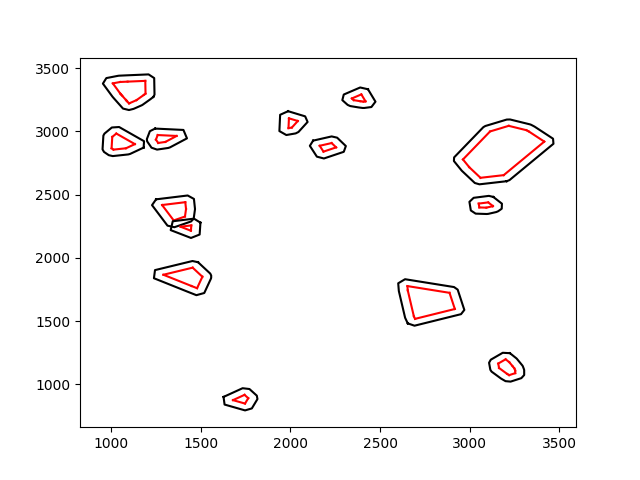

In [21]:
polygons = []
plt.figure()
for label in range(labels.max() + 1):
    points = df_buildings[labels == label].values
    hull = ConvexHull(points)

    if hull.area < 150:
        continue

    polygon = Polygon(points[hull.vertices])
    polygon = polygon.buffer(50, join_style='mitre', mitre_limit=1)
    polygons.append(polygon)
    vertices = np.array(polygon.exterior.coords)

    plt.plot(np.hstack([vertices[:, 0], [vertices[0, 0]]]), np.hstack([vertices[:, 1], [vertices[0, 1]]]), 'k-')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'r-')


### Merge overlapping hulls

13 28


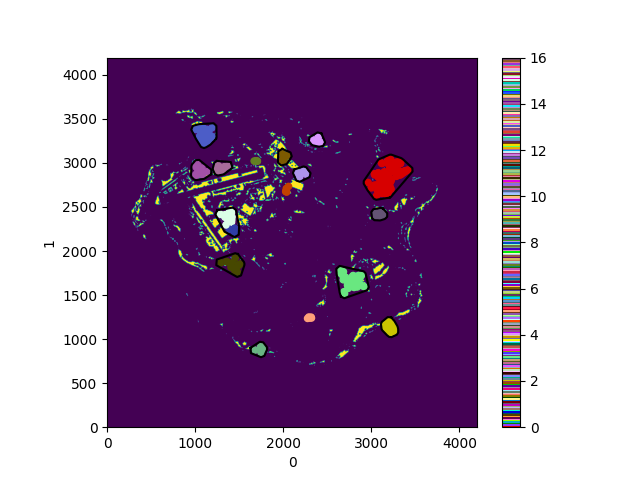

In [22]:
has_changed = True

while has_changed:
    has_changed = False

    for i in range(len(polygons)):
        if polygons[i] is None:
            continue

        for j in range(i + 1, len(polygons)):
            if polygons[j] is None:
                continue

            if not polygons[i].intersects(polygons[j]):
                continue

            has_changed = True
            points = np.vstack([polygons[i].exterior.coords, polygons[j].exterior.coords])
            polygons[i] = Polygon(points[ConvexHull(points).vertices])
            polygons[j] = None

polygons = list(filter(lambda p: p is not None, polygons))
print(len(polygons), max(map(lambda p: len(p.exterior.coords), polygons)))
plt.figure()

for polygon in polygons:
    vertices = np.array(polygon.exterior.coords)
    plt.plot(np.hstack([vertices[:, 0], [vertices[0, 0]]]), np.hstack([vertices[:, 1], [vertices[0, 1]]]), 'k-')

df_buildings.plot.scatter(x=0, y=1, c=labels, cmap=cc.cm.glasbey, ax=plt.gca())
plt.imshow(df_slot_flat_small[-header.z_min:, -header.x_min:], origin='lower')

---
## Export all data

In [27]:
config_tpl = string.Template('KSC_WorldSlotsConfig {m_aLocations {$LOCATIONS} m_pBuildingSlotConfig $BUILDING_SLOT_CONFIG m_mTerrainSlots {$TERRAIN_SLOTS}}')
location_tpl = string.Template('KSC_Location "{$GUID}" {m_eLabel $LABEL m_vCenter $CENTER_X 0 $CENTER_Z m_aPolygon { $POINTS }}')
building_slot_tpl = string.Template('KSC_BuildingSlotConfig "{$GUID}" : "$CONFIG_RESOURCE_NAME" {}')
terrain_slot_tpl = string.Template('KSC_TerrainSlotConfig "{$GUID}" {m_eLabel $LABEL m_mMatrix KSC_TerrainSlotMatrix "{$MAT_GUID}" {m_aRowIdcs { $ROW_IDCS } m_aColIdcs { $COL_IDCS } m_Data { $DATA }}}')

location_entries = []

for polygon in polygons:
    location_entries.append(location_tpl.safe_substitute(
        GUID = os.urandom(8).hex().upper(),
        LABEL = 0,
        CENTER_X = int(polygon.centroid.coords[0][0]),
        CENTER_Z = int(polygon.centroid.coords[0][1]),
        POINTS = ' '.join(map(str, np.array(polygon.exterior.coords).flatten().astype(int)))
    ))

terrain_slot_entries = []

for label, x_list, z_list, val_list in terrain_slots:
    terrain_slot_entries.append(terrain_slot_tpl.safe_substitute(
        GUID = os.urandom(8).hex().upper(),
        LABEL = label,
        MAT_GUID = os.urandom(8).hex().upper(),
        ROW_IDCS = ' '.join(map(str, x_list)),
        COL_IDCS = ' '.join(map(str, z_list)),
        DATA = ' '.join(map(lambda val: f'{np.round(np.degrees(val) + 90, 1)}', val_list)),
    ))

with open(f'KSC_Slots_{Path.cwd().name}.conf', 'w') as stream:
    stream.write(config_tpl.safe_substitute(
        LOCATIONS = ' '.join(location_entries),
        BUILDING_SLOT_CONFIG = building_slot_tpl.safe_substitute(GUID=os.urandom(8).hex().upper(), CONFIG_RESOURCE_NAME='{17EA469D743EC627}Configs/Slots/Eden/KSC_BuildingSlots_Eden.conf'),
        TERRAIN_SLOTS = ' '.join(terrain_slot_entries)
    ))